Reading in all libraries needed for the notebook to run

In [0]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter1d
from scipy.stats import loglaplace,chi2
!pip install matplotlib-label-lines
from labellines import labelLine, labelLines
from pandas import Series
import datetime
from numpy import array
from pylab import rcParams
import itertools
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error 
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras.backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Activation, Dense, RepeatVector, TimeDistributed, Dropout

Data pulled from Raw Data Github link hosted by CSSE at John Hopkins University

In [0]:
#Read in data
url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
df = pd.read_csv(url)
df.head()
print(df.shape)

#Change column names to follow snake format
df = df.rename(columns={"Province/State":"Province_State", "Country/Region":"Country_Region"})
df.fillna("", inplace=True)
df["Country_Province"] = df["Country_Region"] + df["Province_State"]

df.shape

(266, 108)

Only run code below if you would like to get a view of alot of rows within data frames for checks.

In [0]:
#Setting options for display 

#pd.set_option('display.max_rows', 500)
#pd.set_option('display.max_columns', 500)
#pd.set_option('display.width', 1000)

Conducting initial eda with a copy of the original data frame

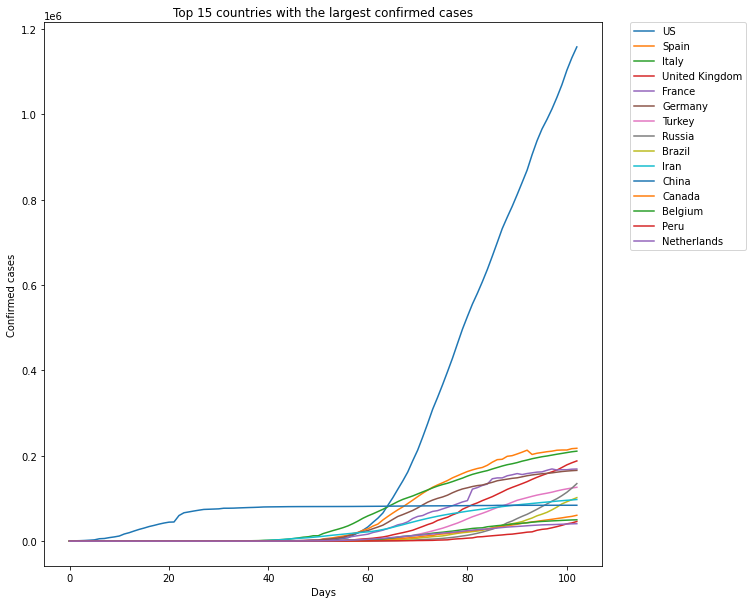

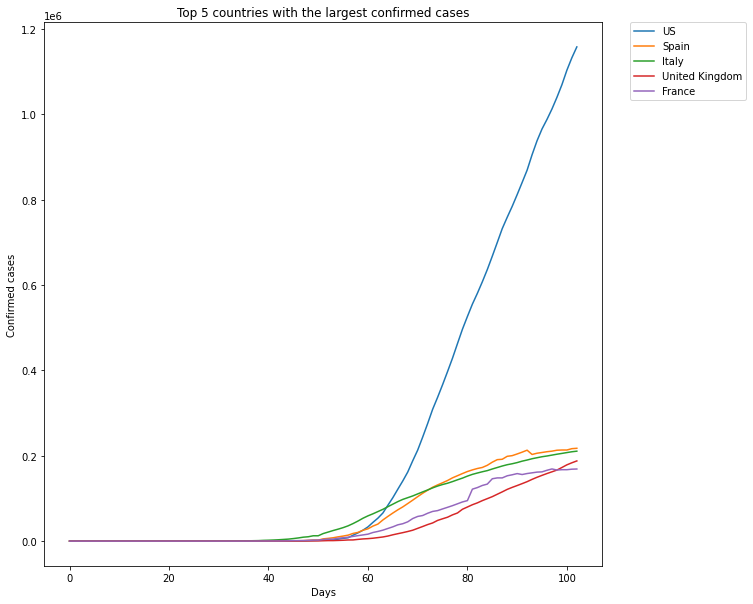

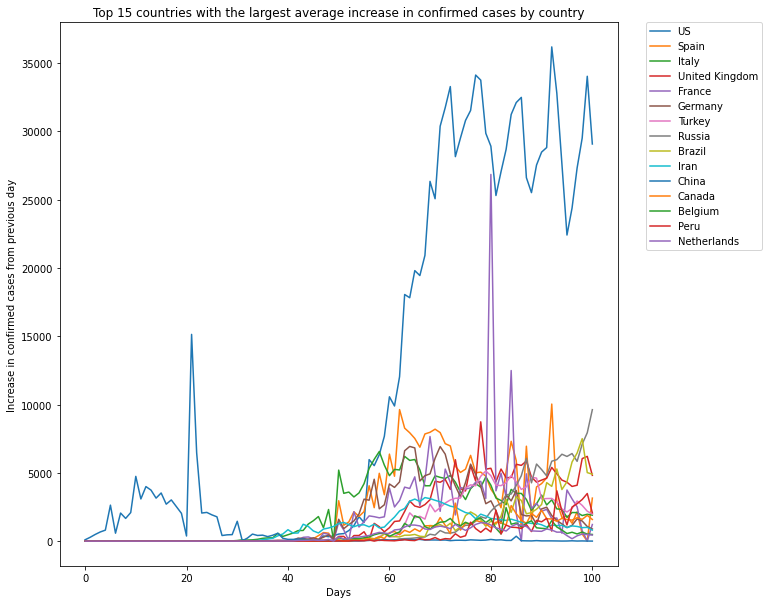

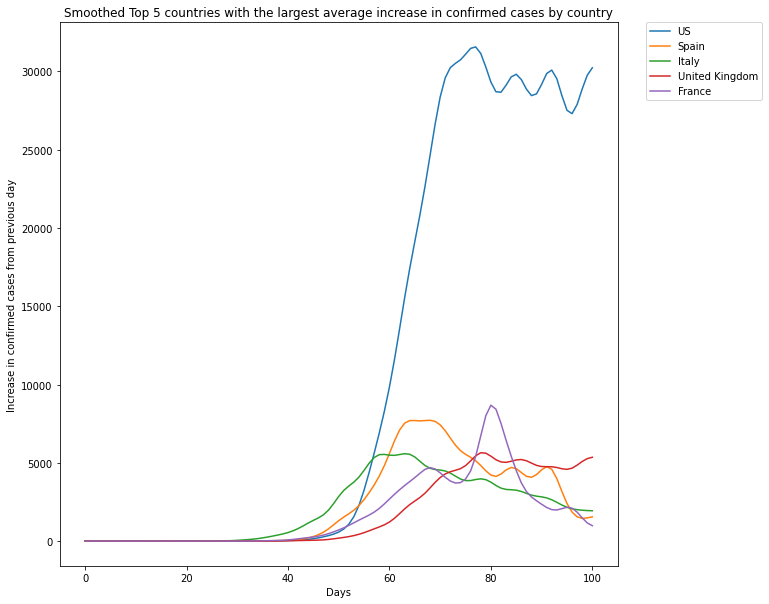

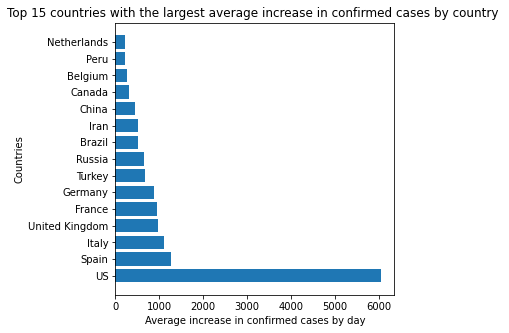

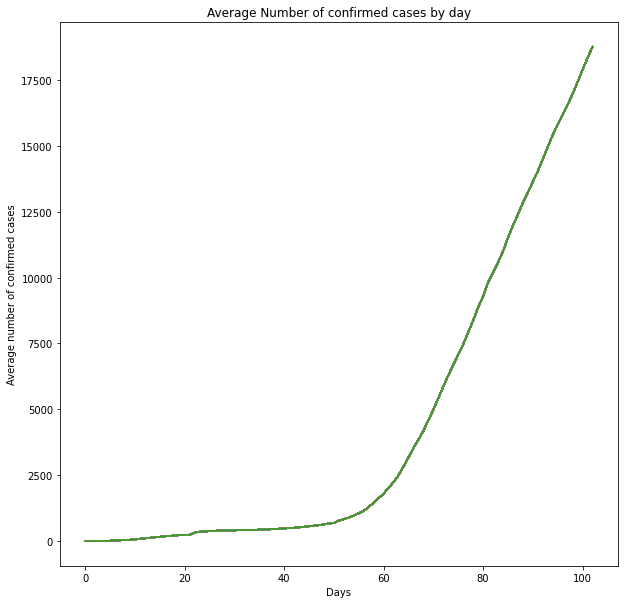

In [0]:
#create copy of main dataframe
df_eda = df.copy()

#Taking the sum of confirmed cases for all country regions
confirmed_country = df_eda.groupby("Country_Region").sum()

#Taking the top 15 countries with the largest number of confirmed cases
top_15 = confirmed_country.sort_values(by="5/2/20", ascending=False).head(n=15)

#Creating line chart of top 15 countries
time = [x for x in range(len(top_15.iloc[:,2:].columns))]
plt.figure(figsize=(10,10))
for i in range(len(top_15.iloc[:,2:])):
  plt.plot(time, top_15.iloc[i,2:], label = str(top_15.index[i]))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title("Top 15 countries with the largest confirmed cases")
plt.xlabel('Days')
plt.ylabel('Confirmed cases')
plt.show()

#Creating line chart of top 5 countries
top_5 = confirmed_country.sort_values(by="5/2/20", ascending=False).head(n=5)
time = [x for x in range(len(top_5.iloc[:,2:].columns))]
plt.figure(figsize=(10,10))
for i in range(len(top_5.iloc[:,2:])):
  plt.plot(time, top_5.iloc[i,2:], label = str(top_5.index[i]))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title("Top 5 countries with the largest confirmed cases")
plt.xlabel('Days')
plt.ylabel('Confirmed cases')
plt.show()

#Need to determine the rate of increase in confirmed cases by country day over day 
growth_array_holder = []
for country in range(len(confirmed_country)):
  country_growth = []
  for day in range(len(confirmed_country.columns[2:])):
    if day == 101:
      break
    else:
      country_growth.append(abs(confirmed_country.iloc[country,2:].iloc[day] - confirmed_country.iloc[country,2:].iloc[day+1]))
  growth_array_holder.append(country_growth)

#Creating the dataframe with the lsit that contains number of increased confirmed cases
cf_growth_country = pd.DataFrame(growth_array_holder, columns = confirmed_country.columns[2:103])
cf_growth_country.index = confirmed_country.index.values

#Determing the average increase in confirmed cases for every country 
avg_growth =[]
for i in range(len(cf_growth_country)):
  avg_growth.append(sum(cf_growth_country.iloc[i])/len(cf_growth_country))
cf_growth_country["Avg_growth"] = avg_growth

#Creating line chart for top 15 countries by the number of increases in confirmed cases
top_15_growth = cf_growth_country.sort_values(by="Avg_growth", ascending=False).head(n=15)
time = [x for x in range(len(top_15_growth.columns)-1)]
plt.figure(figsize=(10,10))
for i in range(len(top_15_growth)):
  plt.plot(time, top_15_growth.iloc[i,:101], label = str(top_15.index[i]))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title("Top 15 countries with the largest average increase in confirmed cases by country")
plt.xlabel('Days')
plt.ylabel('Increase in confirmed cases from previous day')
plt.show()

#Creating line chart for top 5 countries with largest average increase in confirmed cases and smoothed
top_5_growth = cf_growth_country.sort_values(by="Avg_growth", ascending=False).head(n=5)
time = [x for x in range(len(top_5_growth.columns)-1)]
plt.figure(figsize=(10,10))
for i in range(len(top_5_growth)):
  ysmoothed = gaussian_filter1d(top_5_growth.iloc[i,:101], sigma=2)
  plt.plot(time, ysmoothed, label = str(top_5.index[i]))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title("Smoothed Top 5 countries with the largest average increase in confirmed cases by country")
plt.xlabel('Days')
plt.ylabel('Increase in confirmed cases from previous day')
plt.show()

#Barchart of countries with the largest average increase in confirmed cases
plt.figure(figsize=(5,5))
plt.barh(top_15_growth.index.values, top_15_growth.Avg_growth)
plt.title("Top 15 countries with the largest average increase in confirmed cases by country ")
plt.xlabel('Average increase in confirmed cases by day')
plt.ylabel('Countries')
plt.show()

#Creating summary statistics for every day
date_stats = confirmed_country.describe(include=np.number).drop('count').T

#Creating line chart for average number of confirmed cases by day 
time = [x for x in range(len(date_stats)-2)]
plt.figure(figsize=(10,10))
for i in range(len(date_stats)-2):
  plt.plot(time, date_stats.iloc[:,0][2:])
plt.title("Average Number of confirmed cases by day")
plt.xlabel('Days')
plt.ylabel('Average number of confirmed cases')
plt.show()


In [0]:
#Creating new dataframe as copy of original for preprocessing 
df_train = df.copy()
#Remove all columns other than dates
df_train = df_train.drop(columns=["Province_State","Country_Region","Lat","Long"])

#Creating lists to be made into data frame where columns will be data, countries, confirmedcases
date = []
confirmed = []
countries = []
for i in range(len(df_train.Country_Province)):
  for j in range(len(df_train.columns)-1):
    date.append(df_train.columns[j])
    countries.append(df_train.Country_Province[i])
    confirmed.append(df_train.iloc[i,j])

#Creating data frame to make into time series
country_dates_confirmed = {"Date": date, "Countries": countries, "Confirmed": confirmed} 
#Creating seperate training data for lstm modelling
train = pd.DataFrame(country_dates_confirmed, columns = ["Date","Countries","Confirmed"])

#Printing for country Afghanistan to make sure every country has row for all dates
print(train.loc[train["Countries"] == 'Afghanistan'])
#Making data column into object type date
train["Date"] = pd.to_datetime(train["Date"])

#Creating new time variables 
train["Week_of_Year"] = train["Date"].dt.weekofyear
train["Quarter"] = train["Date"].dt.quarter
train["Month"] = train["Date"].dt.month
train["Day_of_Year"] = train["Date"].dt.dayofyear

ts_train = train.copy()
#Labelencoding the country names to be repersented in numerics
label_encoding = LabelEncoder()
train["Country_Code"] = label_encoding.fit_transform(train["Countries"])
train.drop(columns=["Countries"], inplace=True)
train


        Date    Countries  Confirmed
0    1/22/20  Afghanistan          0
1    1/23/20  Afghanistan          0
2    1/24/20  Afghanistan          0
3    1/25/20  Afghanistan          0
4    1/26/20  Afghanistan          0
5    1/27/20  Afghanistan          0
6    1/28/20  Afghanistan          0
7    1/29/20  Afghanistan          0
8    1/30/20  Afghanistan          0
9    1/31/20  Afghanistan          0
10    2/1/20  Afghanistan          0
11    2/2/20  Afghanistan          0
12    2/3/20  Afghanistan          0
13    2/4/20  Afghanistan          0
14    2/5/20  Afghanistan          0
15    2/6/20  Afghanistan          0
16    2/7/20  Afghanistan          0
17    2/8/20  Afghanistan          0
18    2/9/20  Afghanistan          0
19   2/10/20  Afghanistan          0
20   2/11/20  Afghanistan          0
21   2/12/20  Afghanistan          0
22   2/13/20  Afghanistan          0
23   2/14/20  Afghanistan          0
24   2/15/20  Afghanistan          0
25   2/16/20  Afghanistan          0
2

,Date,Confirmed,Week_of_Year,Quarter,Month,Day_of_Year,Country_Code
0,2020-01-22,0,4,1,1,22,0
1,2020-01-23,0,4,1,1,23,0
2,2020-01-24,0,4,1,1,24,0
3,2020-01-25,0,4,1,1,25,0
4,2020-01-26,0,4,1,1,26,0
...,...,...,...,...,...,...,...
27393,2020-04-29,0,18,2,4,120,234
27394,2020-04-30,15,18,2,4,121,234
27395,2020-05-01,15,18,2,5,122,234
27396,2020-05-02,76,18,2,5,123,234


In the below chunk of code, I run a grid search of optimal parameters for ARIMA model, this approach and code logic was largely influenced by Susan Li from her Towardsdatascience article.

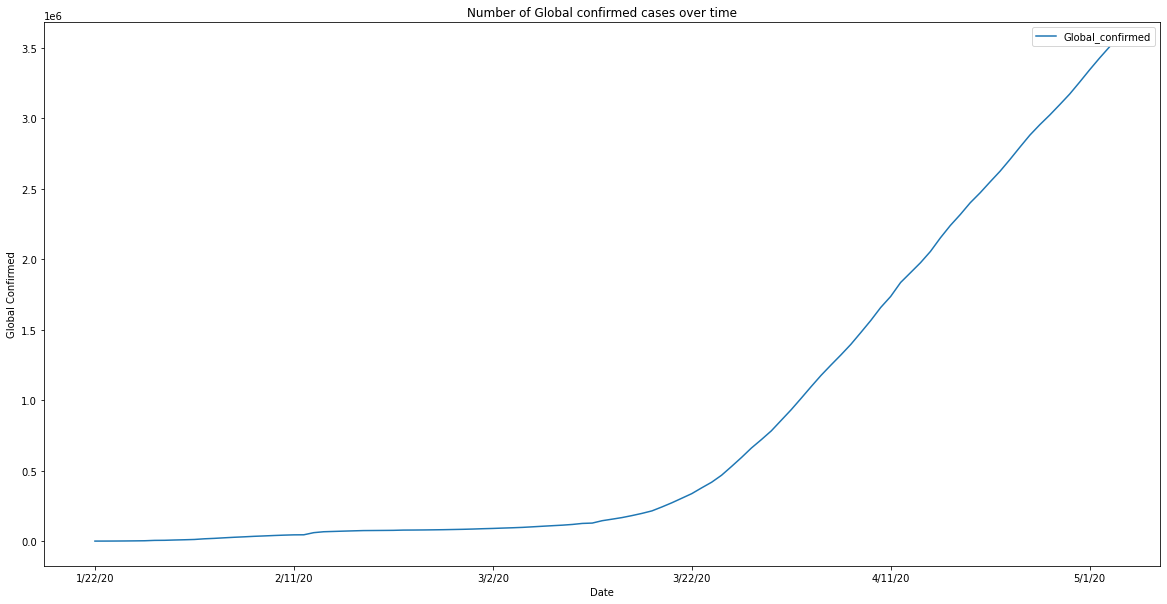

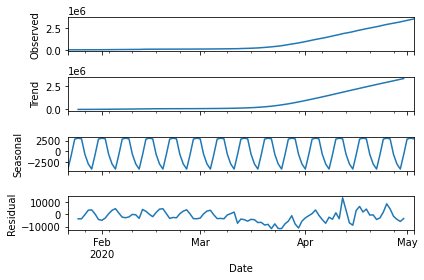

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packa

((1, 1, 1), (1, 1, 1, 12), 1051.3652349447534)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


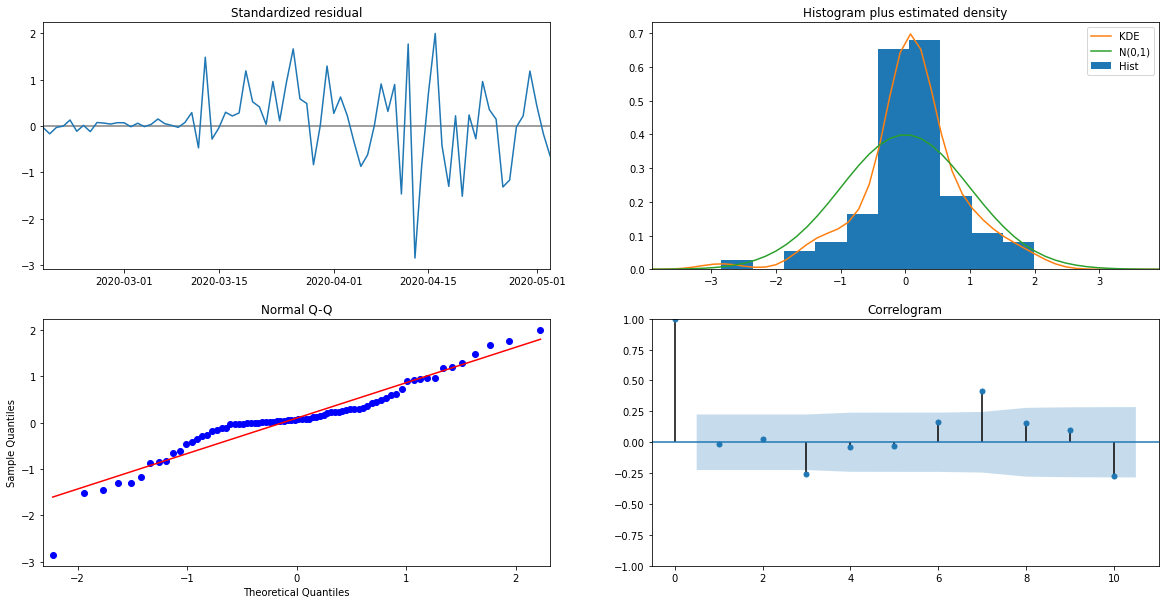

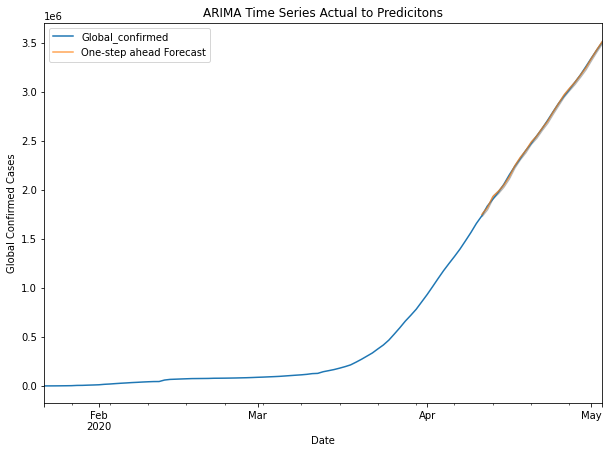

In [0]:
#Creating dataframe of total number of confirmed cases over time
daily_confirmed = []
for i in range(len(confirmed_country.columns)-2):
  daily_confirmed.append(sum(confirmed_country.iloc[:,2:].iloc[:,i]))
date_glo_dict = {"Date":confirmed_country.columns[2:] , "Global_confirmed": daily_confirmed }
ts_global_confirmed = pd.DataFrame(date_glo_dict, columns = ["Date","Global_confirmed"])

#Plotting total number of confirmed cases 
ts_global_confirmed.plot(x="Date",y="Global_confirmed", figsize=(20,10))
plt.title("Number of Global confirmed cases over time")
plt.xlabel('Date')
plt.ylabel('Global Confirmed')
plt.show()

ts_global_confirmed["Date"] = pd.to_datetime(ts_global_confirmed["Date"])
ts_global_confirmed = ts_global_confirmed.set_index("Date")

#Creating decomposed view of global confirmed cases to observe decomposed curves
decomposition = sm.tsa.seasonal_decompose(ts_global_confirmed["Global_confirmed"], model='additive')

fig = decomposition.plot()
plt.show()

#Creating time series train and test for ARIMA
ts_train = ts_global_confirmed[:80]
ts_test = ts_global_confirmed[80:]

#ARIMA GRID_SEARCH CREDIT TO SUSAN LI FROM Towardsdatascience
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

#Loop through all possible combinations for parameters and keep parameters for arima that give best score
score = 100000000 
for param in pdq:
  for param_seasonal in seasonal_pdq:
      mod = sm.tsa.statespace.SARIMAX(ts_train, order=param,
                                      seasonal_order=param_seasonal,
                                      enforce_stationarity=False,
                                      enforce_invertibility=False)
      results = mod.fit()
      if results.aic < score:
        score = results.aic
        optimal_params = (param, param_seasonal, results.aic)

print(optimal_params)
optimal_params[0]

#Create final arima model based on optimal parameters
final_arima_mod = sm.tsa.statespace.SARIMAX(ts_global_confirmed, order=optimal_params[0],
                                      seasonal_order=optimal_params[1],
                                      enforce_stationarity=False,
                                      enforce_invertibility=False)
final_mod_fit = final_arima_mod.fit()
final_mod_fit.summary()

#plot residuals and predicitons to determine validity
final_mod_fit.plot_diagnostics(figsize=(20,10))
plt.show()

#Obtain arima predictions with confidence intervals
arima_pred = final_mod_fit.get_prediction(start=pd.to_datetime("2020-04-11"), dynamic=False)
arima_pred_ci = arima_pred.conf_int()

#plot observed to actuals values 
ax = ts_global_confirmed["2020-01-22":].plot(label='observed')
arima_pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(10, 7))
ax.fill_between(arima_pred_ci.index,
                arima_pred_ci.iloc[:, 0],
                arima_pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Global Confirmed Cases')
plt.title("ARIMA Time Series Actual to Predicitons")
plt.legend()
plt.show()




In this chunk below I create lag variables for all rows in our dataframe used for the LSTM model. The code logic is heavily influenced by Andriy Samoshin.

In [0]:
#Create lag variables for every row and every country
#CREDIT TO Andriy Samoshin FROM KAGGLE FOR FUNCTION
#CAREFUL RUNNING THIS BLOCK OF CODE WILL TAKE LONG TIME

for i in train["Date"].drop_duplicates():
  for j in train["Country_Code"].drop_duplicates():
    org_mask = (train["Date"] == i) & (train["Country_Code"] == j)
    for lag in range(1,10):
      mask_loc = (train["Date"] == (i - timedelta(days=lag))) & (train["Country_Code"] == j)
      try:
          train.loc[org_mask, 'Confirmed_' + str(lag)]=train.loc[mask_loc, "Confirmed"].values
      except:
          train.loc[org_mask, 'Confirmed_' + str(lag)]=0.0



Below I save the data to my google drive to make sure I dont lose the dataframe, takes a long while to run

In [0]:
#from google.colab import drive
#drive.mount('/content/drive')
#train.to_csv(r"/content/drive/My Drive/LSTM_Preprocess_Train.csv")

Reshaping the training dataset to fit into LSTM input which takes 3 inputs and creating a matrix of corresponding confirmed cases

In [0]:
x_vars = []
for i in range(len(train.columns)):
  if(i >= 2):
    x_vars.append(train.columns[i])
train_x = train[x_vars]
train_x = train_x.values.reshape(train_x.shape[0], 1, train_x.shape[1])

train_y = train["Confirmed"]
train_y = train_y.values.reshape(-1,1)

train_x_confirmed, test_x_confirmed, train_y_confirmed, test_y_confirmed = train_test_split(train_x, train_y, test_size=.2, random_state=0)

Creating LSTM Model with drop out and activation layer relu, adam as optimizer and customer loss function.

In [0]:
#Creating root mean square log error function to input into LSTM model
def rmsle(prediction, true):
  assert(prediction.shape[0] == true.shape[0])
  return K.sqrt(K.mean(K.square(K.log(prediction+1) - K.log(true+1))))

#Create lstm nn
all_model = Sequential()
#important to set correct input_shape(*tuple*dimensions)
all_model.add(LSTM(100, activation = "relu", input_shape = (train_x_confirmed.shape[1], train_x_confirmed.shape[2])))
all_model.add(Dropout(0.2))
all_model.add(Dense(64, activation = "relu"))
all_model.add(Dense(32, activation = "relu"))
all_model.add(Dense(1, activation = "relu"))
all_model.compile(optimizer='adam', loss=rmsle)

es = EarlyStopping(monitor='val_loss', min_delta = 0, verbose=0, patience=10, mode='auto')
model_checks = ModelCheckpoint('model_confirmed_checks.txt', monitor='val_loss', verbose=0, save_best_only=True)

#fit data
confirmed_fit = all_model.fit(train_x_confirmed, train_y_confirmed, validation_data=(test_x_confirmed,test_y_confirmed), epochs=200, batch_size=512, callbacks=[es,model_checks])

Epoch 1/200
43/43 [==============================] - 3s 60ms/step - loss: 0.7314 - val_loss: 0.3224
Epoch 2/200
43/43 [==============================] - 2s 51ms/step - loss: 0.2591 - val_loss: 0.2042
Epoch 3/200
43/43 [==============================] - 2s 50ms/step - loss: 0.1968 - val_loss: 0.2005
Epoch 4/200
43/43 [==============================] - 2s 57ms/step - loss: 0.2001 - val_loss: 0.1730
Epoch 5/200
43/43 [==============================] - 2s 50ms/step - loss: 0.1763 - val_loss: 0.1629
Epoch 6/200
43/43 [==============================] - 2s 55ms/step - loss: 0.1701 - val_loss: 0.1523
Epoch 7/200
43/43 [==============================] - 0s 10ms/step - loss: 0.1634 - val_loss: 0.1545
Epoch 8/200
43/43 [==============================] - 0s 9ms/step - loss: 0.1714 - val_loss: 0.1537
Epoch 9/200
43/43 [==============================] - 0s 10ms/step - loss: 0.1663 - val_loss: 0.1793
Epoch 10/200
43/43 [==============================] - 0s 9ms/step - loss: 0.1716 - val_loss: 0.1658
E

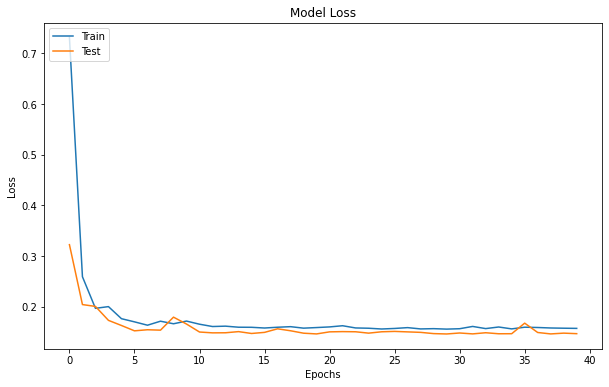

In [0]:
#Chart loss over epochs run
plt.figure(figsize=(10,6))
plt.plot(confirmed_fit.history['loss'], label='Train')
plt.plot(confirmed_fit.history['val_loss'], label='Test')
plt.title("Model Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="upper left")
plt.show()

Compare final predictions to actual confirmed cases ** Key to note that input is unique pairwise values (date, country_code)

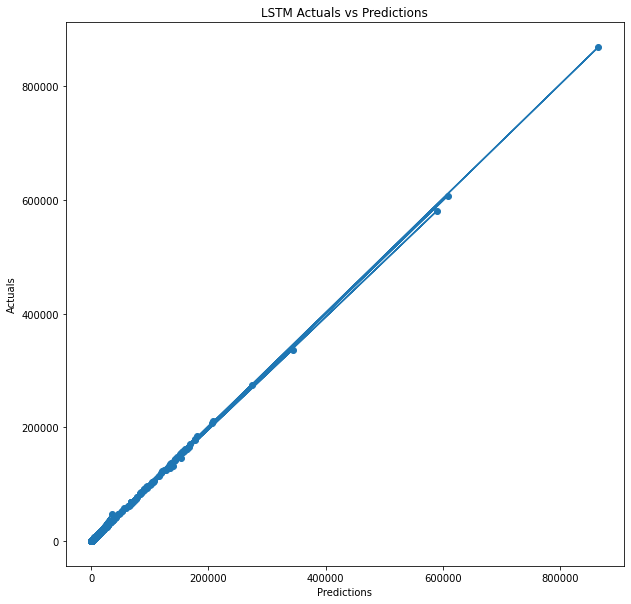

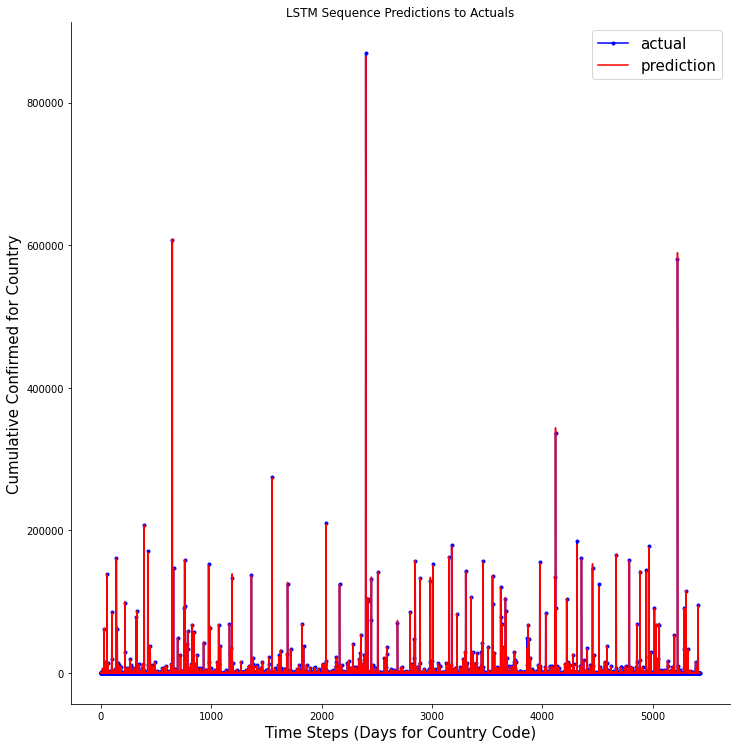

In [0]:
test_pred = all_model.predict(test_x_confirmed)
aa=[x for x in range(5427)]

plt.figure(figsize=(10,10))
plt.scatter(test_pred, test_y_confirmed)
plt.plot(test_pred, test_y_confirmed)
plt.title("LSTM Actuals vs Predictions")
plt.xlabel("Predictions")
plt.ylabel("Actuals")
plt.show();

q_y =[]
for i in range(5427):
  q_y.append(test_y_confirmed[i][0])
q_y

q_y_pred = []
for i in range(5427):
  q_y_pred.append(test_pred[i][0])
q_y_pred[:5427]

plt.figure(figsize=(10,10))
plt.plot(aa, q_y[:5427], marker='.', color="blue", label="actual")
plt.plot(aa, q_y_pred[:5427], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.title("LSTM Sequence Predictions to Actuals")
plt.ylabel('Cumulative Confirmed for Country', size=15)
plt.xlabel('Time Steps (Days for Country Code)', size=15)
plt.legend(fontsize=15)
plt.show();